<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Neuropixels Dataset Exercises </h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">Wednesday, August 28, 2019</h3> 

<img src="../resources/EphysObservatory/neuropixels.png" height="250" width="250"> 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys import ecephys_session
%matplotlib inline

# fix slow autocomplete
%config Completer.use_jedi = False

# Exercises

### 1. Loading sessions

To start, load an `EcephysProjectCache` and use the sessions data to select and load an experimental session containing data from all 6 visual areas ('VISp','VISl','VISal','VISrl','VISam','VISpm').

In [2]:
manifest_path = os.path.join("/allen/scratch/aibstemp/nileg/cache_dir_08_13/manifest.json")
cache = EcephysProjectCache.fixed(manifest=manifest_path)
sessions = cache.get_sessions()

In [5]:
vis_areas = ['VISp','VISl','VISal','VISrl','VISam','VISpm']
all_areas = lambda areas : all(vis_area in areas for vis_area in vis_areas)

In [6]:
sessions[sessions.structure_acronyms.apply(all_areas)].head()

,session_type,specimen_id,genotype,gender,age_in_days,project_code,probe_count,channel_count,unit_count,has_nwb,structure_acronyms
id,,,,,,,,,,,
750749662,brain_observatory_1.1,726162197,wt,M,92.0,NeuropixelVisualCoding,6,509,813,True,"[CA, DG, MB, TH, VISal, VISam, VISl, VISp, VIS..."
755434585,brain_observatory_1.1,730760270,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,0.0,NeuropixelVisualCoding,6,419,688,True,"[CA, DG, MB, TH, VISal, VISam, VISl, VISp, VIS..."
756029989,brain_observatory_1.1,734865738,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,0.0,NeuropixelVisualCoding,6,436,714,True,"[CA, DG, MB, TH, VISal, VISam, VISl, VISp, VIS..."


In [5]:
session_id = 750749662
session = cache.get_session_data(session_id)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 1.3:</b> Make a series of rasters plots showing spiking activity from 20 units recorded from each of the 6 visual cortical areas. To do this,

<ol>
    <li>Loop over probes--extract all spikes from probe within this loop.</li>
    <li>Use function below (**get_units_in_visual_cortex()** ) to return only visual cortical neurons.</li>
    <li>Loop over 20 units in each area--extract unit spike times from probe_spikes and plot raster.</li>
</ol>

<b>HINT:</b> Recall from above that each probe corresponds to a unique visual cortical region. To loop over probes and get the corresponding region for 'get_units_in_visual_cortex', use the <b>zip</b> function in python.
</div>

In [28]:
def get_units_in_visual_cortex(cortical_region_name, data_set):
    '''Inputs:
            cortical_region_name: the name of visual cortical region ('VISp','VISl','VISal','VISrl','VISam','VISpm')
            data_set: data_set object for one ephys experiment
       Returns:
            vis_unit_list: list of unit_IDs in the cortical region '''
    
    # Select dataframe subset of units in cortical region
    subset_unit_df = data_set.unit_df[data_set.unit_df['structure']==cortical_region_name]
    
    # Make a list of unit_ids that are in visual cortical region on specified probe
    vis_unit_list = list(subset_unit_df['unit_id'].values)
    
    return vis_unit_list

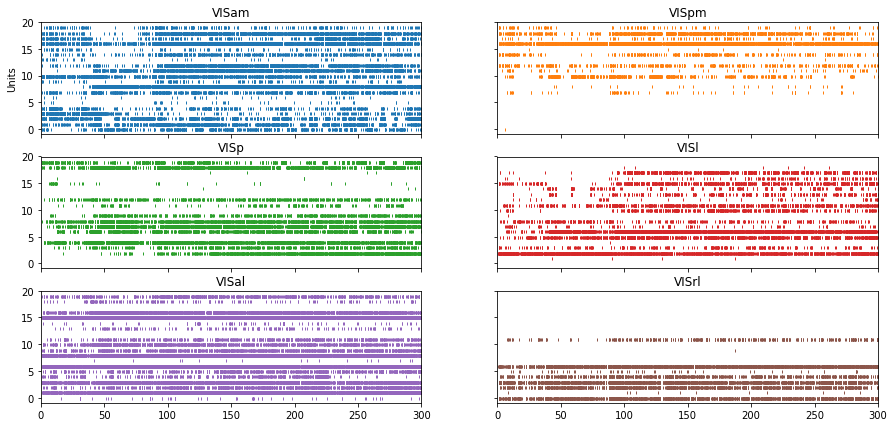

In [29]:
#SOLUTION
# Raster plot showing 20 units simultaneously recorded in each of 6 areas

#Get probes and regions in data_set
probes = data_set.probe_list
regions = data_set.region_list

# Figure setup
fig,ax = plt.subplots(3,2,figsize=(15,7),sharex=True,sharey=True)

#The ravel command gets the six axes (3*2) into a single list.
ax = ax.ravel()     

#List of colors so that a unique color can be used for each plot. 
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Loop over probes. Use a counter variable 'idx' that increments by 1 for every probe
idx = 0
for probe,region in zip(probes,regions):
    probe_spt = data_set.spike_times[probe]                     # Get all spikes from probe
    vis_unit_list = get_units_in_visual_cortex(region,data_set) # Get units in one visual cortical region
    
    # Plot spike times for 20 units
    for i,unit in enumerate(vis_unit_list[:20]):
        spike_times =  probe_spt[unit]                       #Extract spike times for each unit from probe spiketimes
        ax[idx].plot(spike_times,i*np.ones_like(spike_times),'|',color=colors[idx],markersize=3) #fill in the first two entries here
        ax[idx].set_title(region)                           #Use region name as title for each subplot 
    
    idx = idx+1
        
plt.xlim(0,300)
ax[0].set_ylabel('Units')
plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 2.2:</b> Write a function to plot PSTH for a given unit and image. Use your function to plot PSTHs for 6 example units for image 46. Use a bin_width of 5 ms to bin spikes. Your function should have the following signature:

<pre><code>
def image_psth(img, unit_spikes, ax):
    #your code here
    return ax
</code></pre>

where: 
<ul>
    <li>img: the stim table for 1 image</li>
    <li>unit_spikes: the spike times for 1 unit</li>
    <li>ax: the handle of a matplotlib axes object (the modified handle is also the return value)</li>
</ul>
</div>

In [47]:
# SOLUTION
def image_psth(img,unit_spikes,ax=[]):
    
    #Default params
    if not ax:
        fig,ax = plt.subplots(1,1,figsize=(6,3))

    pre_time = 1.#.5
    post_time = 1.#.75

    all_trials = []
    # Get spike train for each trial
    for i,start in enumerate(img.start):
        spikes = unit_spikes[(unit_spikes > start-pre_time) & (unit_spikes < start+post_time)]
        spikes = spikes - start
        all_trials.append(list(spikes))

    # Make PSTH for each trial with 5 ms bins
    bin_width = 0.005
    bins = np.arange(-pre_time,post_time+bin_width,bin_width)   
    all_counts = []
    for trial in all_trials:
        c,edges = np.histogram(trial,bins)
        c = c/bin_width#np.diff(bins[0:2])
        all_counts.append(c)
    centers = edges[:-1] + np.diff(bins)/2
    
    # Plot mean PSTH across trials
    ax.plot(centers,np.mean(all_counts,axis=0))
    ax.axvspan(0,0.25,color='gray',alpha=0.1)
    ax.set_ylabel('Firing rate (spikes/second)')
    ax.set_xlabel('Time (s)')
    ax.set_xlim(pre_time,post_time)

    return ax

/Users/michaelbu/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))


(-0.5, 0.75)

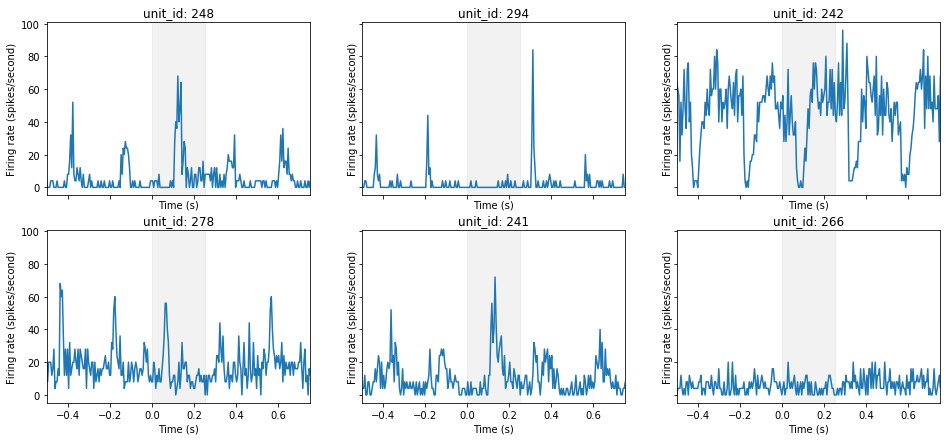

In [48]:
# Figure setup
fig,ax = plt.subplots(2,3,figsize=(16,7),sharex=True,sharey=True)
ax = ax.ravel()

for i,unit in enumerate(ex_unit_ids):
    unit_spikes = ex_probe_spikes[unit]
    image_psth(img,unit_spikes,ax[i])
    ax[i].set_title('unit_id: ' + unit)
    
ax[0].set_xlim(-0.5,0.75)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 2.2:</b> Write a function to plot PSTH for a given unit and image. Use your function to plot PSTHs for 6 example units for image 46. Use a bin_width of 5 ms to bin spikes. Your function should have the following signature:

<pre><code>
def image_psth(img, unit_spikes, ax):
    #your code here
    return ax
</code></pre>

where: 
<ul>
    <li>img: the stim table for 1 image</li>
    <li>unit_spikes: the spike times for 1 unit</li>
    <li>ax: the handle of a matplotlib axes object (the modified handle is also the return value)</li>
</ul>
</div>

In [47]:
# SOLUTION
def image_psth(img,unit_spikes,ax=[]):
    
    #Default params
    if not ax:
        fig,ax = plt.subplots(1,1,figsize=(6,3))

    pre_time = 1.#.5
    post_time = 1.#.75

    all_trials = []
    # Get spike train for each trial
    for i,start in enumerate(img.start):
        spikes = unit_spikes[(unit_spikes > start-pre_time) & (unit_spikes < start+post_time)]
        spikes = spikes - start
        all_trials.append(list(spikes))

    # Make PSTH for each trial with 5 ms bins
    bin_width = 0.005
    bins = np.arange(-pre_time,post_time+bin_width,bin_width)   
    all_counts = []
    for trial in all_trials:
        c,edges = np.histogram(trial,bins)
        c = c/bin_width#np.diff(bins[0:2])
        all_counts.append(c)
    centers = edges[:-1] + np.diff(bins)/2
    
    # Plot mean PSTH across trials
    ax.plot(centers,np.mean(all_counts,axis=0))
    ax.axvspan(0,0.25,color='gray',alpha=0.1)
    ax.set_ylabel('Firing rate (spikes/second)')
    ax.set_xlabel('Time (s)')
    ax.set_xlim(pre_time,post_time)

    return ax

/Users/michaelbu/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))


(-0.5, 0.75)

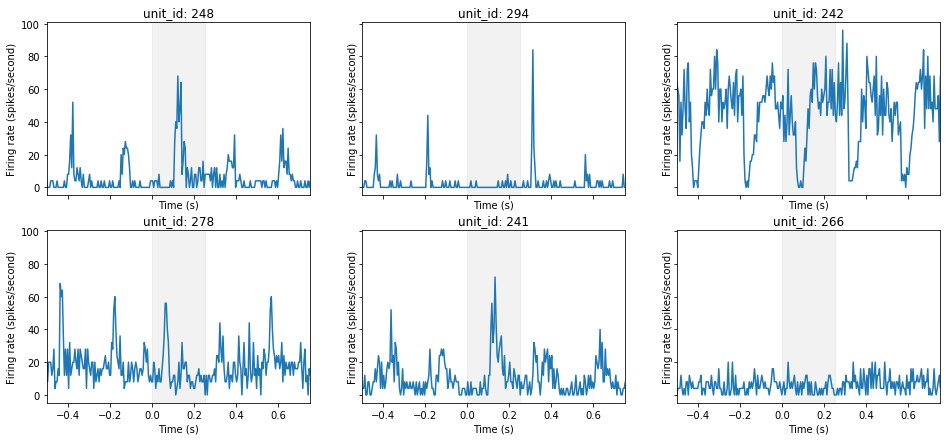

In [48]:
# Figure setup
fig,ax = plt.subplots(2,3,figsize=(16,7),sharex=True,sharey=True)
ax = ax.ravel()

for i,unit in enumerate(ex_unit_ids):
    unit_spikes = ex_probe_spikes[unit]
    image_psth(img,unit_spikes,ax[i])
    ax[i].set_title('unit_id: ' + unit)
    
ax[0].set_xlim(-0.5,0.75)

## # Tuning curves

- compare static/drifting grating curves
    - could combine with comparing PSTH for same examples
- compare across contrast values

##  # Correlations and correlograms

Maybe include signal correlations (of tuning curves), correlations of spontaneous activity (zero-lag, time bin=??), and cross-correlograms?

Code in walkthrough is slow because computing correlogram for all pairs - change to only single or few examples.

Not sure if we should include noise correlations on stimulus presentations. (from last year: Homework 3.1 Compute signal and noise correlation across all drifting grating stimulus parameters and compute average noise correlation. Compare this to signal and noise correlation across all natural scene stimuli. )

# Unit properties

***?? The spike width (and some other metrics, including multi-channel) are already computed in the units table. We could instead have them use the calculated values, and plot examples to better understand the metrics ***

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 4.1:</b> Compute spike duration for all units in this experiment and plot histogram of values.
Hints:
<ol>
    <li>Concatenate waveforms in a matrix</li>
    <li>Compute location of trough and peak using np.argmax() and np.argmin()</li>
    <li>Compute difference between time of trough and peak</li>
    <li>Plot histogram of spikes duration (time between trough and peak)</li>
</ol>
</div>

In [72]:
# Concatenate waveforms into matrix
wv = []
for k,w in spike_waveforms.iteritems():
    for kk,ww in w.iteritems():
        wv.append(ww)  
wv = np.array(wv)

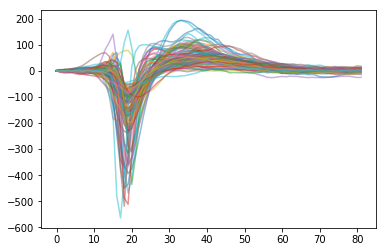

In [73]:
# Plot 100 waveforms in this data_set
fig,ax = plt.subplots(1,1,figsize=(6,4))
for w in wv[:100]:
    ax.plot(w,alpha=0.5)

In [74]:
# Compute trough-to-peak duration
duration = np.argmax(wv,axis=1) - np.argmin(wv,axis=1)
duration = 1/30000.*duration*1000 # Convert samples to ms

Text(0.5,0,'Spike duration (ms)')

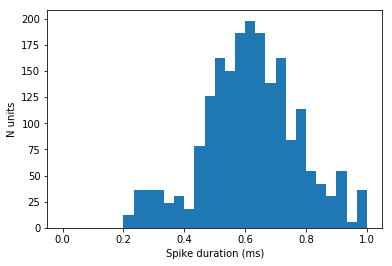

In [75]:
# Plot histogram of duration
plt.hist(duration,bins=30,range=(0,1));
plt.ylabel('N units')
plt.xlabel('Spike duration (ms)')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 4.3:</b>
<ol>
    <li>Get spike times for 50 units with highest SNR and at least 3000 total spikes.</li>
    <li>Plot ISI distribution for each unit</li>
    <li>Do the ISI distributions vary between cells?</li>
</ol>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Task 4.1:</b> Plot the inter-spike interval distribution with 1 ms bins. Show 2 graphs with different x-limits: (0, 20 ms) and (0, 200 ms). 
Hint: use the function np.diff to compute the difference between adjacent spike times (i.e. the inter-spike interval).
</div>

In [78]:
#SOLUTION
# Compute inter-spike interval distribution for 1 unit
isi = np.diff(unit_spikes)
isi = isi*1000 # convert to ms
print(isi[:20])

[  18.3666682   190.80001595   41.23333678 1979.60016549   59.96667168
   61.90000517 1374.63344825 3364.20028124 2527.03354459   12.50000104
   19.86666833  351.90002942   32.60000273  138.40001157   38.73333657
   45.33333712   67.10000561   20.7666684    33.30000278   57.13333811]


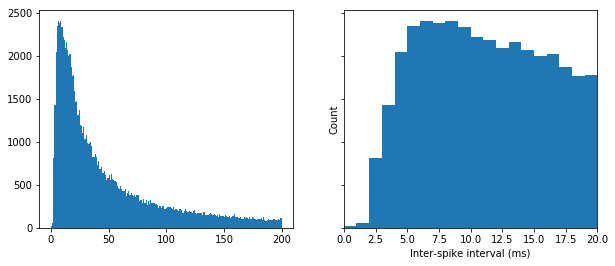

In [79]:
# Plot ISI distribution as histogram with 1 ms bins
fig,ax = plt.subplots(1,2,figsize=(10,4),sharey=True)
ax[0].hist(isi,bins=200,range=(0,200))
ax[1].hist(isi,bins=200,range=(0,200))
ax[1].set_xlim(0,20)
plt.ylabel('Count')
plt.xlabel('Inter-spike interval (ms)')
plt.show()

In [80]:
# Get unit_df with metadata including snr
snr_df = data_set.unit_df[data_set.unit_df.structure == 'VISp']
snr_df.head()

,unit_id,probe,structure,snr,depth,channel
667,222,probeC,VISp,4.77,-1320,250
668,223,probeC,VISp,7.01134,-1320,250
669,224,probeC,VISp,3.42435,-1300,253
670,225,probeC,VISp,3.3767,-1280,254
671,226,probeC,VISp,2.07795,-1260,256


In [81]:
# Sort df by highest snr values
snr_df_2 = snr_df.sort_values(by=['snr'], ascending=False)
snr_df_2.head()

,unit_id,probe,structure,snr,depth,channel
689,245,probeC,VISp,7.16157,-1160,266
668,223,probeC,VISp,7.01134,-1320,250
729,293,probeC,VISp,6.4157,-800,302
696,252,probeC,VISp,6.08229,-1040,278
713,270,probeC,VISp,5.79568,-940,289


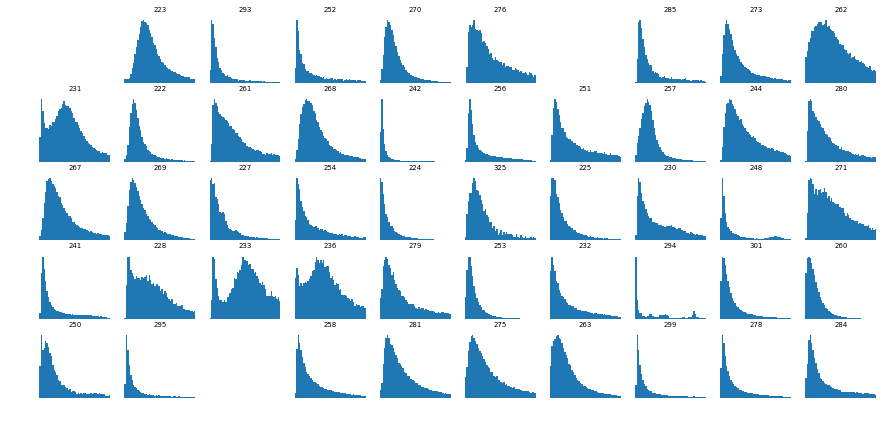

In [82]:
# Get spike times for 50 units with highest SNR and at least 3000 total spikes
unit_list = snr_df_2.unit_id.values[:50]
probe_v1 = 'probeC'
cortical_area = 'VISp'
probe_v1_spikes = data_set.spike_times[probe_v1]

# Figure setup
fig,ax = plt.subplots(5,10,figsize=(15,7),sharex=True)
ax = ax.ravel()

# Plot ISI distribution for each unit
for i,unit in enumerate(unit_list):
        unit_spikes = probe_v1_spikes[unit]
        if len(unit_spikes) > 3000:
            isi = np.diff(unit_spikes)
            ax[i].hist(isi,bins=50,range=(0,0.3))
            ax[i].set_title(str(unit_list[i]),fontsize=7)

plt.xlim(0,0.3)

for i in ax:
    i.axis('off')

# LFP

### # Spike-triggered average of LFP

The LFP is the product of the coordinated activity of a large number of cells localized near the probe, many more than those we have spike times for. Thus, one way of understanding relationships between single neurons and the population is to look at relationships between spike times and the LFP. One example is the spike-triggered average of the LFP signal. If a certain pattern is often present in the LFP before or a after a cell fires, the averaging will help to isolate this signal and average out the noise. 

Pick a unit of your choice, and calculate the spike-triggered average of the LFP signal. For each spike time of the unit, pick out a fixed window of the LFP aligned around the spike time. To keep the analysis and visualization simple, we'll stick to looking at the LFP on the peak channel of the unit for now. 

In [11]:
# Get spike times and channel info for a single unit
unit_id = session.units.index.values[0]
spikes = session.spike_times[unit_id]
peak_ch = session.units.loc[unit_id, "peak_channel_id"]
probe_id = session.units.loc[unit_id, "probe_id"]

In [12]:
lfp = session.get_lfp(probe_id).loc[dict(channel=peak_ch)]

KeyError: 849743024

In [ ]:
# Time before and after spike
pre_time = 1.
post_time = 1.


# Make list that will contain the LFP around each spike
spike_triggered_lfp = []

#Loop through every spike
for i, spike in enumerate(spikes):
    
    t0 = spike - pre_time
    t1 = spike + post_time
    lfp_subset = lfp.loc[dict(channel=peak_ch, time=slice(t0, t1))]
    
    spike_triggered_lfp.append(lfp_subset)

Calculate the average of these short windows of LFP across all the spikes and visualize the results.

In [ ]:
sta_lfp = np.mean(spike_triggered_lfp)

plt.plot(sta_lfp)

### # Hilbert transform and instantaneous amplitude

Another way to analyze how an oscillatory signal varies with time is to extract its instantaneous amplitude using a mathematical tool called the Hilbert transform. The function `scipy.signal.hilbert` adds a second dimension to a signal (as a complex variable), such that the resulting *analytic signal* now has a well-defined nonzero amplitude and phase at every instant in time! (See http://www.rdgao.com/roemerhasit_Hilbert_Transform/ for a nice explanation.)

- (a) Find the peak frequency of the signal using the welsh periodogram, then filter it using a window of +/- 2 Hz around this frequency
- (b) Calculate the analytic signal from your filtered LFP
- (c) Then use `np.abs` and `np.angle` to calculate the amplitude and phase of the signal. Visualize the filtered LFP along with its amplitude and phase.

In [ ]:
f, psd = scipy.signal.welch(v, fs, nperseg=1000)

In [ ]:
import scipy.signal
freq_window = (4, 10)
filt_order = 3
fs = 1/(t[1]-t[0])
b, a = scipy.signal.butter(filt_order, freq_window, btype='bandpass', fs=fs)
v_alpha = scipy.signal.lfilter(b, a, v)

In [ ]:
lfp_z = scipy.signal.hilbert(v_filtered)
lfp_amp = np.abs(lfp_z)
lfp_phase = np.angle(lfp_z)

In [ ]:
idx = np.logical_and(t>=window[0], t<window[1])
window = [5, 15]

plt.figure(figsize=(8,2))
plt.plot(t[idx], v_alpha[idx],'b',label='beta-filtered signal',alpha=.5)
plt.plot(t[idx], lfp_amp[idx],'k',label='beta amp',alpha=.5)
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')

In [ ]:
beta_phase = np.angle(sp.signal.hilbert(x_filt))

samp_plot = range(14000,15000)
plt.figure(figsize=(8,4))
plt.subplot(3,1,1)
plt.plot(t[idx], v_alpha[idx],'k')
plt.ylabel('Beta-filtered\nVoltage (a.u.)')
plt.subplot(3,1,1)
plt.plot(t[idx], lfp_amp[idx],'k')
plt.ylabel('Amplitude (uV)')
plt.subplot(3,1,2)
plt.plot(t[idx], lfp_phase[idx],'k')
plt.xlabel('Time (s)')
plt.ylabel('Phase (rad)')